# topic modeling pipeline

This notebook will walk you through:
1. data reterival from SQL database
2. Pre-processing data
3. Running topic modeling (different models)
4. post processing (including showing topics, topic-doc distribution, etc.)
5. Storing results into DB

# imports

In [1]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from pre_processing import transition_labeling
from post_processing import topic_selection, date2days, topic_terms_bert
# from rpy2 import robjects #loading R inside Python
#importing functions to read pandas DF
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# from rpy2.robjects.packages import importr
# from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired



#import R base library
# base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /home/amh418/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amh418/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amh418/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amh418/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


loading stop words

In [ ]:
#downloading github repo for down-sampling==> you only need this once!
# !git clone https://github.com/aminmarani/authorless-tms.git

In [2]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

#adding the selected stop_words
stop_words.extend(['go','going','got','want','time','really','good','life','let','even','get',
                  'always','answer','back','day','feel','love','need','never','people',
                  'question','right','see','still','things','today','way','week'])

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

# Loading data from SQL database

First creating a connection

**In order to create a connection from anywhere in LU network you need to run the command below in terminal. Replace your username with amh418 in the command below.**

ssh -L 3306:127.0.0.1:3306 -N -f amh418@128.180.111.76   #it will ask for lehigh pass

on network (128.180.111.76)
outside the network (ssh.lehigh.edu)

**if you need to kill to SSH forwarding use the link below**

https://superuser.com/questions/87014/how-do-i-remove-an-ssh-forwarded-port


In [3]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

Retreiving all the posts

**We are exlcuding recoverwithmeda for now**

In [4]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [5]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

In [6]:
#concatenating the old dataset to the new one
last_id = max([i[0] for i in myresult])+1
myresult_ = [tuple([i[1]+last_id]+list(i[2:])) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


Language detection

keeping only English language posts/documents

In [8]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

100%|██████████| 17322/17322 [01:24<00:00, 204.13it/s]

after removing non-english posts,the size of the documents are: 17143


# preprocessing the data

First, removing html tags

prepare the corupus

In [9]:
import re

#removing tags from texts 
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#remvoing post that  include tree_htem
proc_texts = [re.sub(r"\{'comment'.*?\}",'',i) if "tree_html" in i else i for i in proc_texts]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])

In [10]:
#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

14043
13350


# Term Frequency

Term frequency and Term/doc frequency

**This is only analysis we already add stop words from these anlaysis to stop_words defined above**

In [ ]:
import collections

#extracting uni-grams
terms = []
for s in list(text_df.text):
    terms.extend(s.split())

#computing frequency of each term
freqs = collections.Counter(terms)
sorted(freqs.items(),key= lambda x:x[1],reverse=True )[0:10]
# freqs

In [14]:
#terms-document proportion
term_doc = {k:0 for k,v in freqs.items() if v>len(text_df)*0.05}

#compute term_doc
for s in list(text_df.text):
    for k in term_doc.keys():
        if k in s.split():
            term_doc[k]+=1

In [15]:
#terms that appear in 20% or more of documents
candids = {k:v for k,v in term_doc.items() if v>=len(text_df)*0.10}
set(candids.keys())
# selected_stop_words = set(candids.keys())
# selected_stop_words 

{'body', 'eat', 'eating', 'food'}

# Blog distribution

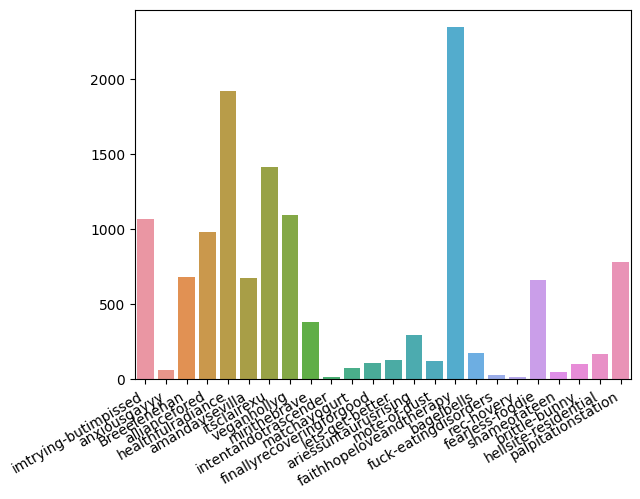

In [16]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

blog_dist = Counter(list(text_df.blog))
sns.barplot(x=list(blog_dist.keys()),y=list(blog_dist.values()))
a = plt.xticks(rotation=30,ha='right') 
# list(blog_dist.values())

Processing documens for Topicalizer

In [18]:
# text_df[['date','original_text','url']].rename(columns={'original_text':'entry','url':'Link'}).to_csv('./data/processed_ed.csv')

# Author down-sampling

down-sampling terms that are more specific to an author

In [19]:
# vocab = set()

# for tx in list(text_df.text):
#     tokens = tx.split()
#     [vocab.add(t) for t in tokens]

# with open('./data/temp_vocab_corpus.txt','w') as tfile:
#     tfile.writelines([i+'\n' for i in list(vocab)])

# print('size of dictionary is {0}'.format(len(vocab)))

In [20]:
# #storing corpus for down-sampling (we send the pre-processed docs)
# text_df[['blog','text']].to_csv('./data/temp_documents_corpus.txt',index=True,sep='\t',
#                                 header=False,encoding="UTF-8")

In [21]:
# #running down-sampling ==> if the original file in repo pops error you need to make changes in the downsample_corpus.py as stated below
# #line 68: term_means = np.mean(author_term_freqs, axis=0).ravel() 
# #line 71: term_vars = np.var(author_term_freqs, axis=0, ddof=1).ravel()
# #line 83: author_term_freqs = author_term_freqs.toarray()#added 2023,Nov
# #line 88: author_freqs = author_term_freqs[:, term_id].ravel()#.getA1() #added 2023,Nov
# !python3 ./authorless-tms/downsample_corpus.py --input ./data/temp_documents_corpus.txt --output ./data/temp_documents_corpus_new003.txt --vocab ./data/temp_vocab_corpus.txt --threshold 0.03

# loading from down-sampled dataset

In [22]:
# #updating text_df
# new_df = pd.read_csv('./data/temp_documents_corpus_new005.txt',sep='\t',header=None,
#                      names=['id','blog','text'])

# #replacing down-sampled data with original data
# for id,row in tqdm(new_df.iterrows()):
#     text_df.loc[text_df.id==id,'text'] = row['text']
#     # text_df.at[int(id),'text'] = row['text']

# #removing the ones that were deleted during down-sampling
# text_df = text_df[text_df.id.isin(new_df.id)]

# print('Number of documents after down-sampling: {0}'.format(len(text_df)))

# Running topic modeling (with or without evaluation)

In [23]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')

# utils.install_packages('stm',repos="https://cloud.r-project.org")

In [54]:
#prevalence (use/non-use)

#converting to date format
# text_df.date = pd.to_datetime(text_df.date)
# days = date2days(text_df)

# labels = transition_labeling(days)

# text_df['prevalence'] = ""
# for id,label in labels.items():
#     text_df.loc[text_df.id==id,'prevalence'] = label

#prevalence Author (blog)
# text_df['prevalence'] = text_df['blog']



# #content (instagram-tumbler)

# source = ['tumblr' if 'tumblr' in str(i) else 'instagram' for i in list(text_df.url) ]
# text_df['content'] = source

In [49]:
#prevalence only (source: instagram/tumblr)
# source = ['tumblr' if 'tumblr' in str(i) else 'instagram' for i in list(text_df.url) ]
# text_df['prevalence'] = source

In [68]:
from inspect import signature

# min_topic_size=10 or #min_cluster_size

<Signature (top_n_words: int = 10, nr_repr_docs: int = 5, nr_samples: int = 500, nr_candidate_words: int = 100, random_state: int = 42)>

In [17]:
from lda_mallet import lda_score
import pickle

is_eval = True #not evaluating the model
lon,upn = 5,41 #lowwer and upper topic number for evaluation
#need to provide number of topics and other specification
# model_spec = {'name':'LDA','K':16,'epochs':3500,'burnin_iteration':150,'after_iteration_burnin':50,
             # 'save_flag':True,'save_path':'LDA_test','alpha_sum':30.0}#burnin_iteration=20,after_iteration_burnin=50
stm_lda_epochs = 50  #increase lda nits
stm_lda_burnin = 150
# model_spec = {'name':'STM','K':16,'epochs':500,'prevalence':'prevalence','content':'content','pre_trained_model': 'LDA',\
#                 'burnin_iteration':stm_lda_burnin if stm_lda_epochs>stm_lda_burnin else stm_lda_epochs-1,\
#               'LDA_epochs':stm_lda_epochs,'alpha':30,'save_flag':False}

model_spec = {'name':'bertopic','K':12,'min_topic_size':70,'min_samples':20,'save_flag':False}

if model_spec['name'] == 'LDA':
    if is_eval:
        #loading LDA mallet evaluation score
        from gensim.corpora import Dictionary
        from pre_processing import prepare_corpus
        #creating data vocab
        dict = Dictionary([i.split() for i in list(text_df.text)])
        #saving it to pass it to score object
        with open ('./data/ED_vocab.obj','wb') as vfile:
            pickle.dump(dict,vfile)
        wiki_vocab_dict_path = './data/wiki_sampled5p_vocab.obj'
        with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
            wiki_vocab_dict = pickle.load(vfile)


        npmis = []
        for n_topics in range(lon,upn,1):
            #removing terms that are not in the Wiki Vocab
            #pre_processing and tokenizing docs
            # pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
            #                                                set(dict.values()).difference(set(wiki_vocab_dict.values()))\
            #                                        .union(['denying']))
            pre_processed_docs,_ = preprocess_data(list(text_df.text))
            #preparing corpus
            vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
            #temp save of vocab file
            with open ('./data/ED_vocab.tmp','wb') as vfile:
                pickle.dump(vocab_dict,vfile)
            
            scorer = lda_score(num_topics=n_topics,alpha=10,optimize_interval=10,iterations=2000,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path=wiki_vocab_dict_path,npmi_skip_threshold=0.30)
            
            scorer.fit(doc_term_mat)#fitting an LDA Mallet
            npmis.append([n_topics,scorer.score()])
    else: 
        #removing previously created mallet_file
        try:
            os.remove('MalletInstance_ {0}'.format(model_spec['save_path'])) 
            os.remove('MalletState_ {0} .gz'.format(model_spec['save_path']))
            os.remove('MalletSpec_ {0}'.format(model_spec['save_path']))
        except:#in case we don't have any files
            pass
        robjects.r.source('LDA_R.R')
        copy_text_df = text_df.copy()
        ans = robjects.r.findTopics(docs = copy_text_df,n_topics = model_spec['K'],epochs = model_spec['epochs'],
                                    burnin_iteration = model_spec['burnin_iteration'],
                                    after_iteration_burnin =  model_spec['after_iteration_burnin'],
                                    save_flag=model_spec['save_flag'],alpha_sum=model_spec['alpha_sum'],
                                    save_path = model_spec['save_path'])
        top_terms = np.asarray(ans[1])
        topic_doc_dist = np.asarray(ans[0][0]).T
        term_probab = ans[0][1]
        topic_vocab = ans[0][2]
        
        
elif model_spec['name'] == 'STM':
    #loading STM.R
    robjects.r.source('stm.R')
    
    if is_eval:
        
        npmis = []
        for n_topics in range(lon,upn,1):
            print('\n\nRunning STM with {0} topics and other details as below:'.format(n_topics))
            print({k:v for k,v in model_spec.items() if k != 'K'})
            #running STM
            ans = robjects.r.run_stm(docs = text_df[['id','text','prevalence','content']],topic_n=n_topics,max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],nits = model_spec['LDA_epochs'],
                                 burnin = model_spec['burnin_iteration'],alpha=model_spec['alpha'],
                                 save_flag = False)
            #initializing scorer
            scorer = lda_score(num_topics=n_topics,alpha=-1,optimize_interval=-1,iterations=-1,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path='./data/wiki_sampled5p_vocab.obj',npmi_skip_threshold=0.30)
            #setting vocabulary of wikipedia
            with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
                wiki_vocab_dict = pickle.load(vfile)
            scorer.wiki_vocab_dict = wiki_vocab_dict
            #extracting top terms
            top_terms = [[str(i) for i in ls if i in scorer.wiki_vocab_dict.token2id.keys()][0:20] \
             for ls in np.asarray(ans[1]).reshape(n_topics,50,order='F')]
            scorer.all_top_terms = top_terms
            #save the NPMI
            npmis.append([n_topics,scorer.score()])
            
    else: 
        ans = robjects.r.run_stm(docs = text_df[['id','text','prevalence','content']],topic_n=model_spec['K'],max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],nits = model_spec['LDA_epochs'],
                                 burnin = model_spec['burnin_iteration'],alpha=model_spec['alpha'],
                                 save_flag = True)
        #converting outputs to readable values
        outs = dict(zip(ans[0].names, list(ans[0])))
        beta = dict(zip(outs['beta'].names, list(outs['beta'])))
        #extracting information from STM
        top_terms = [' '.join(s) for s in np.asarray(ans[1]).reshape(model_spec['K'],50,order='F')]
        topic_doc_dist = outs['theta']
        term_probab = np.exp(beta['logbeta'][0])
        topic_vocab = outs['vocab']
        ids = pd.DataFrame(ans[2]).T[0]#ids of the remaini
        text_df = text_df[text_df.id.isin(ids)]
        
elif model_spec['name'] == 'bertopic':
    #you have to set the representation top terms to the number you'd like to see as top terms
    representation_model = KeyBERTInspired(top_n_words=50) 
    docs = text_df.original_text
    #         docs = text_df.text
    if is_eval:
        npmis = []
        for n_topics in range(lon,upn,1):
            print('\n\nRunning BERTopic with {0} topics and other details as below:'.format(n_topics))
            print({k:v for k,v in model_spec.items() if k != 'K'})
            npmi_runs = []
            for _ in range(2): #two runs and then average
                #running bertopic
                from hdbscan import HDBSCAN
                hdbscan_model = HDBSCAN(min_cluster_size=model_spec['min_topic_size'],
                                        min_samples=model_spec['min_samples'],prediction_data=True)
                topic_model = BERTopic(nr_topics=n_topics,calculate_probabilities=True,verbose=True,
                           top_n_words=50,representation_model=representation_model,
                                      min_topic_size=model_spec['min_topic_size'],
                                       hdbscan_model=hdbscan_model).fit(docs)
                #initializing scorer
                scorer = lda_score(num_topics=n_topics,alpha=-1,optimize_interval=-1,iterations=-1,wiki_path='./data/wiki_sampled_5p.txt',
                          db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                          wiki_vocab_dict_path='./data/wiki_sampled5p_vocab.obj',npmi_skip_threshold=0.15)
                #setting vocabulary of wikipedia
                with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
                    wiki_vocab_dict = pickle.load(vfile)
                scorer.wiki_vocab_dict = wiki_vocab_dict
                #extracting top terms
                top_terms = []
                for ls in list(topic_model.get_topic_info().Representation):
                    res = []
                    for i in ls:
                        res.extend([j for j in i.split() if j not in res and j in scorer.wiki_vocab_dict.token2id.keys()])
                    top_terms.append(res[0:20])
    #             top_terms = [[str(i) for i in ls if i in scorer.wiki_vocab_dict.token2id.keys()][0:20] \
    #              for ls in list(topic_model.get_topic_info().Representation)]
    #             top_terms = [' '.join(i) for i in list(topic_model.get_topic_info().Representation)]
                scorer.all_top_terms = top_terms
                #save the NPMI
                if len(top_terms) == n_topics:
                    npmi_runs.append(scorer.score())
            npmis.append([n_topics,np.mean(npmi_runs)])
            
    else:
        topic_model = BERTopic(nr_topics=model_spec['K'],calculate_probabilities=True,verbose=True,
                       top_n_words=50,representation_model=representation_model).fit(docs)
        top_terms = [' '.join(i) for i in list(topic_model.get_topic_info().Representation)]
#         topic_doc_dist = np.array([i/np.sum(i) for i in topic_model.probabilities_])
        topic_doc_dist = np.array([[1.0-np.sum(i)]+list(i) for i in topic_model.probabilities_])
        #getting representative documents
        documents = pd.DataFrame({"Document": docs,
                          "ID": range(len( text_df)),
                          "Topic": topic_model.topics_})
        repr_docs, _, _,_ = topic_model._extract_representative_docs(c_tf_idf=topic_model.c_tf_idf_,
                                                          documents=documents,
                                                          topics=topic_model.topic_representations_ ,
                                                          nr_repr_docs=50)
        term_probab = topic_terms_bert(topic_model,len(top_terms)-1)
        topic_vocab = None




Running BERTopic with 5 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:30:31,899 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:30:39,848 - BERTopic - Reduced dimensionality
2024-01-22 22:30:40,830 - BERTopic - Clustered reduced embeddings
2024-01-22 22:30:43,102 - BERTopic - Reduced number of topics from 3 to 3


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:31:50,921 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:31:58,872 - BERTopic - Reduced dimensionality
2024-01-22 22:32:00,327 - BERTopic - Clustered reduced embeddings
2024-01-22 22:32:07,133 - BERTopic - Reduced number of topics from 28 to 5


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.03 missed term-pairs < allowed misses = 0.15


Running BERTopic with 6 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:33:17,824 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:33:26,669 - BERTopic - Reduced dimensionality
2024-01-22 22:33:28,083 - BERTopic - Clustered reduced embeddings
2024-01-22 22:33:34,898 - BERTopic - Reduced number of topics from 27 to 6


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.11 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:34:45,454 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:34:53,604 - BERTopic - Reduced dimensionality
2024-01-22 22:34:54,988 - BERTopic - Clustered reduced embeddings
2024-01-22 22:35:02,039 - BERTopic - Reduced number of topics from 27 to 6


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Running BERTopic with 7 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:36:12,523 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:36:23,211 - BERTopic - Reduced dimensionality
2024-01-22 22:36:24,627 - BERTopic - Clustered reduced embeddings
2024-01-22 22:36:31,431 - BERTopic - Reduced number of topics from 27 to 7


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.02 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:37:43,812 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:37:51,768 - BERTopic - Reduced dimensionality
2024-01-22 22:37:53,235 - BERTopic - Clustered reduced embeddings
2024-01-22 22:38:00,149 - BERTopic - Reduced number of topics from 28 to 7


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.02 missed term-pairs < allowed misses = 0.15


Running BERTopic with 8 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:39:12,054 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:39:20,936 - BERTopic - Reduced dimensionality
2024-01-22 22:39:21,940 - BERTopic - Clustered reduced embeddings
2024-01-22 22:39:24,229 - BERTopic - Reduced number of topics from 3 to 3


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:40:31,390 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:40:39,417 - BERTopic - Reduced dimensionality
2024-01-22 22:40:40,835 - BERTopic - Clustered reduced embeddings
2024-01-22 22:40:47,917 - BERTopic - Reduced number of topics from 29 to 8


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.02 missed term-pairs < allowed misses = 0.15


Running BERTopic with 9 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:42:00,393 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:42:08,405 - BERTopic - Reduced dimensionality
2024-01-22 22:42:09,870 - BERTopic - Clustered reduced embeddings
2024-01-22 22:42:17,078 - BERTopic - Reduced number of topics from 31 to 9


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.06 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:43:28,282 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:43:36,274 - BERTopic - Reduced dimensionality
2024-01-22 22:43:37,801 - BERTopic - Clustered reduced embeddings
2024-01-22 22:43:44,920 - BERTopic - Reduced number of topics from 30 to 9


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Running BERTopic with 10 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:44:57,742 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:45:08,535 - BERTopic - Reduced dimensionality
2024-01-22 22:45:09,930 - BERTopic - Clustered reduced embeddings
2024-01-22 22:45:17,182 - BERTopic - Reduced number of topics from 29 to 10


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.03 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:46:29,494 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:46:37,569 - BERTopic - Reduced dimensionality
2024-01-22 22:46:38,992 - BERTopic - Clustered reduced embeddings
2024-01-22 22:46:46,182 - BERTopic - Reduced number of topics from 28 to 10


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.05 missed term-pairs < allowed misses = 0.15


Running BERTopic with 11 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:47:59,380 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:48:07,578 - BERTopic - Reduced dimensionality
2024-01-22 22:48:09,069 - BERTopic - Clustered reduced embeddings
2024-01-22 22:48:16,520 - BERTopic - Reduced number of topics from 31 to 11


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.06 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:49:29,361 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:49:37,310 - BERTopic - Reduced dimensionality
2024-01-22 22:49:38,727 - BERTopic - Clustered reduced embeddings
2024-01-22 22:49:45,973 - BERTopic - Reduced number of topics from 29 to 11


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.03 missed term-pairs < allowed misses = 0.15


Running BERTopic with 12 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:50:58,077 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:51:09,854 - BERTopic - Reduced dimensionality
2024-01-22 22:51:11,316 - BERTopic - Clustered reduced embeddings
2024-01-22 22:51:18,744 - BERTopic - Reduced number of topics from 29 to 12


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.02 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:52:30,973 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:52:39,008 - BERTopic - Reduced dimensionality
2024-01-22 22:52:40,011 - BERTopic - Clustered reduced embeddings
2024-01-22 22:52:42,201 - BERTopic - Reduced number of topics from 2 to 2




Running BERTopic with 13 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:53:50,274 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:53:58,361 - BERTopic - Reduced dimensionality
2024-01-22 22:53:59,763 - BERTopic - Clustered reduced embeddings
2024-01-22 22:54:07,135 - BERTopic - Reduced number of topics from 26 to 13


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.06 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:55:19,532 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:55:27,494 - BERTopic - Reduced dimensionality
2024-01-22 22:55:28,905 - BERTopic - Clustered reduced embeddings
2024-01-22 22:55:36,312 - BERTopic - Reduced number of topics from 28 to 13


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.03 missed term-pairs < allowed misses = 0.15


Running BERTopic with 14 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:56:48,816 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:56:57,598 - BERTopic - Reduced dimensionality
2024-01-22 22:56:59,017 - BERTopic - Clustered reduced embeddings
2024-01-22 22:57:06,707 - BERTopic - Reduced number of topics from 30 to 14


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.07 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:58:21,129 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:58:29,022 - BERTopic - Reduced dimensionality
2024-01-22 22:58:30,404 - BERTopic - Clustered reduced embeddings
2024-01-22 22:58:37,913 - BERTopic - Reduced number of topics from 27 to 14


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Running BERTopic with 15 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 22:59:51,110 - BERTopic - Transformed documents to Embeddings
2024-01-22 22:59:59,064 - BERTopic - Reduced dimensionality
2024-01-22 23:00:00,439 - BERTopic - Clustered reduced embeddings
2024-01-22 23:00:07,951 - BERTopic - Reduced number of topics from 28 to 15


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:01:21,716 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:01:29,739 - BERTopic - Reduced dimensionality
2024-01-22 23:01:31,092 - BERTopic - Clustered reduced embeddings
2024-01-22 23:01:38,512 - BERTopic - Reduced number of topics from 26 to 15


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Running BERTopic with 16 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:02:51,395 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:03:00,132 - BERTopic - Reduced dimensionality
2024-01-22 23:03:01,094 - BERTopic - Clustered reduced embeddings
2024-01-22 23:03:03,379 - BERTopic - Reduced number of topics from 3 to 3


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:04:11,984 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:04:19,991 - BERTopic - Reduced dimensionality
2024-01-22 23:04:21,468 - BERTopic - Clustered reduced embeddings
2024-01-22 23:04:29,219 - BERTopic - Reduced number of topics from 31 to 16


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.04 missed term-pairs < allowed misses = 0.15


Running BERTopic with 17 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:05:43,020 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:05:50,907 - BERTopic - Reduced dimensionality
2024-01-22 23:05:52,321 - BERTopic - Clustered reduced embeddings
2024-01-22 23:05:59,979 - BERTopic - Reduced number of topics from 28 to 17


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.09 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:07:13,103 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:07:21,241 - BERTopic - Reduced dimensionality
2024-01-22 23:07:22,661 - BERTopic - Clustered reduced embeddings
2024-01-22 23:07:30,320 - BERTopic - Reduced number of topics from 29 to 17


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.07 missed term-pairs < allowed misses = 0.15


Running BERTopic with 18 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:08:43,933 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:08:52,868 - BERTopic - Reduced dimensionality
2024-01-22 23:08:54,272 - BERTopic - Clustered reduced embeddings
2024-01-22 23:09:02,042 - BERTopic - Reduced number of topics from 27 to 18


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.07 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:10:15,443 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:10:23,593 - BERTopic - Reduced dimensionality
2024-01-22 23:10:25,057 - BERTopic - Clustered reduced embeddings
2024-01-22 23:10:32,922 - BERTopic - Reduced number of topics from 29 to 18


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.05 missed term-pairs < allowed misses = 0.15


Running BERTopic with 19 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:11:47,655 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:11:55,688 - BERTopic - Reduced dimensionality
2024-01-22 23:11:57,215 - BERTopic - Clustered reduced embeddings
2024-01-22 23:12:05,314 - BERTopic - Reduced number of topics from 32 to 19


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.07 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:13:21,345 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:13:29,284 - BERTopic - Reduced dimensionality
2024-01-22 23:13:30,725 - BERTopic - Clustered reduced embeddings
2024-01-22 23:13:38,654 - BERTopic - Reduced number of topics from 30 to 19


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.05 missed term-pairs < allowed misses = 0.15


Running BERTopic with 20 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:14:52,250 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:15:01,100 - BERTopic - Reduced dimensionality
2024-01-22 23:15:02,472 - BERTopic - Clustered reduced embeddings
2024-01-22 23:15:10,427 - BERTopic - Reduced number of topics from 26 to 20


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.05 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:16:23,957 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:16:34,901 - BERTopic - Reduced dimensionality
2024-01-22 23:16:36,381 - BERTopic - Clustered reduced embeddings
2024-01-22 23:16:44,524 - BERTopic - Reduced number of topics from 31 to 20


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.06 missed term-pairs < allowed misses = 0.15


Running BERTopic with 21 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:17:59,177 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:18:07,155 - BERTopic - Reduced dimensionality
2024-01-22 23:18:08,533 - BERTopic - Clustered reduced embeddings
2024-01-22 23:18:16,774 - BERTopic - Reduced number of topics from 28 to 21


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:19:33,029 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:19:41,067 - BERTopic - Reduced dimensionality
2024-01-22 23:19:42,510 - BERTopic - Clustered reduced embeddings
2024-01-22 23:19:50,581 - BERTopic - Reduced number of topics from 29 to 21


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.08 missed term-pairs < allowed misses = 0.15


Running BERTopic with 22 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:21:05,055 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:21:13,993 - BERTopic - Reduced dimensionality
2024-01-22 23:21:15,408 - BERTopic - Clustered reduced embeddings
2024-01-22 23:21:23,577 - BERTopic - Reduced number of topics from 29 to 22


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.07 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:22:38,846 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:22:49,758 - BERTopic - Reduced dimensionality
2024-01-22 23:22:51,249 - BERTopic - Clustered reduced embeddings
2024-01-22 23:22:59,520 - BERTopic - Reduced number of topics from 31 to 22


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.08 missed term-pairs < allowed misses = 0.15


Running BERTopic with 23 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:24:15,633 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:24:23,630 - BERTopic - Reduced dimensionality
2024-01-22 23:24:25,149 - BERTopic - Clustered reduced embeddings
2024-01-22 23:24:33,415 - BERTopic - Reduced number of topics from 30 to 23


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.09 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:25:50,782 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:26:01,399 - BERTopic - Reduced dimensionality
2024-01-22 23:26:02,898 - BERTopic - Clustered reduced embeddings
2024-01-22 23:26:11,178 - BERTopic - Reduced number of topics from 30 to 23


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.08 missed term-pairs < allowed misses = 0.15


Running BERTopic with 24 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:27:28,020 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:27:37,045 - BERTopic - Reduced dimensionality
2024-01-22 23:27:38,455 - BERTopic - Clustered reduced embeddings
2024-01-22 23:27:46,631 - BERTopic - Reduced number of topics from 26 to 24


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:29:02,999 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:29:13,726 - BERTopic - Reduced dimensionality
2024-01-22 23:29:15,156 - BERTopic - Clustered reduced embeddings
2024-01-22 23:29:23,356 - BERTopic - Reduced number of topics from 28 to 24


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.09 missed term-pairs < allowed misses = 0.15


Running BERTopic with 25 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:30:38,985 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:30:47,048 - BERTopic - Reduced dimensionality
2024-01-22 23:30:48,441 - BERTopic - Clustered reduced embeddings
2024-01-22 23:30:56,744 - BERTopic - Reduced number of topics from 27 to 25


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:32:14,541 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:32:22,677 - BERTopic - Reduced dimensionality
2024-01-22 23:32:24,162 - BERTopic - Clustered reduced embeddings
2024-01-22 23:32:32,597 - BERTopic - Reduced number of topics from 31 to 25


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.11 missed term-pairs < allowed misses = 0.15


Running BERTopic with 26 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:33:49,556 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:33:57,506 - BERTopic - Reduced dimensionality
2024-01-22 23:33:58,868 - BERTopic - Clustered reduced embeddings
2024-01-22 23:34:03,063 - BERTopic - Reduced number of topics from 26 to 26


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:35:20,930 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:35:28,892 - BERTopic - Reduced dimensionality
2024-01-22 23:35:30,395 - BERTopic - Clustered reduced embeddings
2024-01-22 23:35:38,920 - BERTopic - Reduced number of topics from 31 to 26


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Running BERTopic with 27 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:36:55,367 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:37:03,405 - BERTopic - Reduced dimensionality
2024-01-22 23:37:04,858 - BERTopic - Clustered reduced embeddings
2024-01-22 23:37:13,542 - BERTopic - Reduced number of topics from 29 to 27


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:38:30,005 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:38:37,996 - BERTopic - Reduced dimensionality
2024-01-22 23:38:39,451 - BERTopic - Clustered reduced embeddings
2024-01-22 23:38:48,031 - BERTopic - Reduced number of topics from 28 to 27


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.09 missed term-pairs < allowed misses = 0.15


Running BERTopic with 28 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:40:06,964 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:40:17,842 - BERTopic - Reduced dimensionality
2024-01-22 23:40:19,328 - BERTopic - Clustered reduced embeddings
2024-01-22 23:40:28,000 - BERTopic - Reduced number of topics from 31 to 28


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.10 missed term-pairs < allowed misses = 0.15


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:41:46,404 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:41:54,559 - BERTopic - Reduced dimensionality
2024-01-22 23:41:55,946 - BERTopic - Clustered reduced embeddings
2024-01-22 23:42:00,208 - BERTopic - Reduced number of topics from 28 to 28


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.12 missed term-pairs < allowed misses = 0.15


Running BERTopic with 29 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:43:18,775 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:43:26,748 - BERTopic - Reduced dimensionality
2024-01-22 23:43:28,121 - BERTopic - Clustered reduced embeddings
2024-01-22 23:43:32,309 - BERTopic - Reduced number of topics from 26 to 26


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:44:40,336 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:44:48,418 - BERTopic - Reduced dimensionality
2024-01-22 23:44:49,434 - BERTopic - Clustered reduced embeddings
2024-01-22 23:44:51,714 - BERTopic - Reduced number of topics from 3 to 3
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 30 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:46:00,600 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:46:11,599 - BERTopic - Reduced dimensionality
2024-01-22 23:46:13,030 - BERTopic - Clustered reduced embeddings
2024-01-22 23:46:17,314 - BERTopic - Reduced number of topics from 28 to 28


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:47:25,771 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:47:34,764 - BERTopic - Reduced dimensionality
2024-01-22 23:47:36,229 - BERTopic - Clustered reduced embeddings
2024-01-22 23:47:40,625 - BERTopic - Reduced number of topics from 30 to 30


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.14 missed term-pairs < allowed misses = 0.15


Running BERTopic with 31 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:48:57,044 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:49:05,047 - BERTopic - Reduced dimensionality
2024-01-22 23:49:06,511 - BERTopic - Clustered reduced embeddings
2024-01-22 23:49:10,837 - BERTopic - Reduced number of topics from 29 to 29


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:50:19,291 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:50:27,415 - BERTopic - Reduced dimensionality
2024-01-22 23:50:28,904 - BERTopic - Clustered reduced embeddings
2024-01-22 23:50:33,337 - BERTopic - Reduced number of topics from 31 to 31


Load NPMI coherence DB. 
Number of keys : 1948257
skipping 0.13 missed term-pairs < allowed misses = 0.15


Running BERTopic with 32 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:51:54,380 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:52:02,459 - BERTopic - Reduced dimensionality
2024-01-22 23:52:03,821 - BERTopic - Clustered reduced embeddings
2024-01-22 23:52:07,961 - BERTopic - Reduced number of topics from 26 to 26


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:53:15,103 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:53:23,248 - BERTopic - Reduced dimensionality
2024-01-22 23:53:24,654 - BERTopic - Clustered reduced embeddings
2024-01-22 23:53:28,875 - BERTopic - Reduced number of topics from 27 to 27
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 33 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:54:37,773 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:54:45,920 - BERTopic - Reduced dimensionality
2024-01-22 23:54:47,428 - BERTopic - Clustered reduced embeddings
2024-01-22 23:54:51,794 - BERTopic - Reduced number of topics from 30 to 30


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:56:00,560 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:56:08,516 - BERTopic - Reduced dimensionality
2024-01-22 23:56:10,036 - BERTopic - Clustered reduced embeddings
2024-01-22 23:56:14,454 - BERTopic - Reduced number of topics from 31 to 31
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 34 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:57:23,193 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:57:31,113 - BERTopic - Reduced dimensionality
2024-01-22 23:57:32,102 - BERTopic - Clustered reduced embeddings
2024-01-22 23:57:34,407 - BERTopic - Reduced number of topics from 3 to 3


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-22 23:58:42,250 - BERTopic - Transformed documents to Embeddings
2024-01-22 23:58:52,762 - BERTopic - Reduced dimensionality
2024-01-22 23:58:54,113 - BERTopic - Clustered reduced embeddings
2024-01-22 23:58:58,278 - BERTopic - Reduced number of topics from 26 to 26
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 35 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:00:06,766 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:00:15,642 - BERTopic - Reduced dimensionality
2024-01-23 00:00:17,175 - BERTopic - Clustered reduced embeddings
2024-01-23 00:00:21,663 - BERTopic - Reduced number of topics from 32 to 32


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:01:30,623 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:01:38,741 - BERTopic - Reduced dimensionality
2024-01-23 00:01:40,198 - BERTopic - Clustered reduced embeddings
2024-01-23 00:01:44,508 - BERTopic - Reduced number of topics from 29 to 29
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 36 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:02:52,209 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:03:02,849 - BERTopic - Reduced dimensionality
2024-01-23 00:03:04,276 - BERTopic - Clustered reduced embeddings
2024-01-23 00:03:08,602 - BERTopic - Reduced number of topics from 29 to 29


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:04:28,275 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:04:36,303 - BERTopic - Reduced dimensionality
2024-01-23 00:04:37,661 - BERTopic - Clustered reduced embeddings
2024-01-23 00:04:41,878 - BERTopic - Reduced number of topics from 27 to 27
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 37 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:05:50,423 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:05:59,364 - BERTopic - Reduced dimensionality
2024-01-23 00:06:00,802 - BERTopic - Clustered reduced embeddings
2024-01-23 00:06:05,142 - BERTopic - Reduced number of topics from 29 to 29


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:07:12,626 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:07:23,388 - BERTopic - Reduced dimensionality
2024-01-23 00:07:24,817 - BERTopic - Clustered reduced embeddings
2024-01-23 00:07:29,182 - BERTopic - Reduced number of topics from 30 to 30
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 38 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:08:36,834 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:08:47,636 - BERTopic - Reduced dimensionality
2024-01-23 00:08:49,023 - BERTopic - Clustered reduced embeddings
2024-01-23 00:08:53,332 - BERTopic - Reduced number of topics from 28 to 28


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:10:02,245 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:10:10,321 - BERTopic - Reduced dimensionality
2024-01-23 00:10:11,699 - BERTopic - Clustered reduced embeddings
2024-01-23 00:10:15,933 - BERTopic - Reduced number of topics from 26 to 26
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 39 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:11:23,736 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:11:34,438 - BERTopic - Reduced dimensionality
2024-01-23 00:11:35,409 - BERTopic - Clustered reduced embeddings
2024-01-23 00:11:37,704 - BERTopic - Reduced number of topics from 3 to 3


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:12:44,651 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:12:53,510 - BERTopic - Reduced dimensionality
2024-01-23 00:12:54,513 - BERTopic - Clustered reduced embeddings
2024-01-23 00:12:56,767 - BERTopic - Reduced number of topics from 3 to 3
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




Running BERTopic with 40 topics and other details as below:
{'name': 'bertopic', 'min_topic_size': 70, 'min_samples': 20, 'save_flag': False}


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:14:04,742 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:14:15,239 - BERTopic - Reduced dimensionality
2024-01-23 00:14:16,633 - BERTopic - Clustered reduced embeddings
2024-01-23 00:14:20,842 - BERTopic - Reduced number of topics from 27 to 27


Batches:   0%|          | 0/418 [00:00<?, ?it/s]

2024-01-23 00:15:30,200 - BERTopic - Transformed documents to Embeddings
2024-01-23 00:15:40,720 - BERTopic - Reduced dimensionality
2024-01-23 00:15:42,275 - BERTopic - Clustered reduced embeddings
2024-01-23 00:15:46,859 - BERTopic - Reduced number of topics from 33 to 33
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amh418/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [64]:
# text_df[['id','text','prevalence','content']].to_csv('./data/stm_temp.csv')

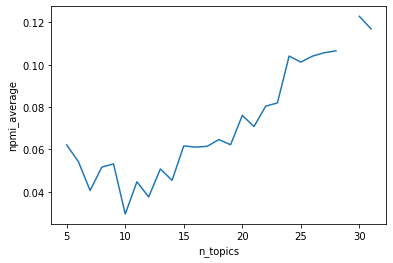

In [18]:
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
# df = pd.concat([df,pd.DataFrame(npmis,columns=['n_topics','npmi_average'])])

sns.lineplot(data=df,x='n_topics',y='npmi_average')

# df.to_csv('./result/npmi_{0}{1}{2}.csv'.format(model_spec['name'],model_spec['prevalence'],
#                                               model_spec['content']))

df.to_csv('./result/npmi_{0}_min_topic_size={1}_min_samples={2}.csv'.format(model_spec['name'],
                                                            model_spec['min_topic_size'],model_spec['min_samples']))

<AxesSubplot:xlabel='n_topics', ylabel='npmi_average'>

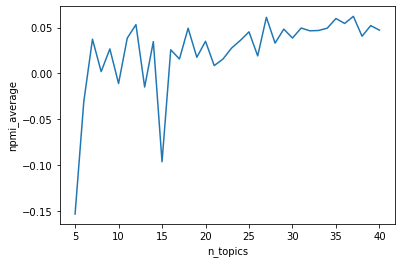

In [13]:
# df = pd.read_csv('./result/npmi_bertopic.csv')
# df = pd.concat([df,pd.read_csv('./result/npmi_bertopic_31_40.csv')])
# sns.lineplot(data=df,x='n_topics',y='npmi_average')

In [15]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5640,-1_yourself_life_being_feel,"[yourself, life, being, feel, eat, myself, goi...","[Tw! Exercise stuff So, for my recovery i star..."
1,0,4169,0_therapy_eating_feel_eat,"[therapy, eating, feel, eat, healthy, her, be,...",[Therapy .. // the relationship > everything e...
2,1,1070,1_recovery_work_run_am,"[recovery, work, run, am, be, being, yourself,...",[picture this: ☕️you're minding your own busin...
3,2,763,2_travel_happy_going_feel,"[travel, happy, going, feel, life, hope, you, ...",[So we've been opening up A LOT recently on th...
4,3,735,3_hospital_inpatient_going_care,"[hospital, inpatient, going, care, go, be, bab...",[This self quarantine is hard and I really mis...
5,4,495,4_eatingdisorders_eating_disorders_disorder,"[eatingdisorders, eating, disorders, disorder,...","[In honor of #MentalHealthAwarenessMonth, it i..."
6,5,276,5_instagram_blog_tumblr_being,"[instagram, blog, tumblr, being, blogs, social...",[last night i caught myself starting to go dow...
7,6,135,6_reading_book_books_read,"[reading, book, books, read, writing, kindle, ...",[Throwback to an outback sunrise and the clear...
8,7,27,7_summer_warm_bikini_warmer,"[summer, warm, bikini, warmer, cold, hot, temp...","[When we were in the desert, we had a whole co..."
9,8,26,8_college_school_toschool_studying,"[college, school, toschool, studying, major, u...",[Question: What are you gonna do about school?...


# Post-processing

topic distribution and topic selection

for topic selection I used elbow method (selecting top topics till we get to the highest gap)

In [155]:
#topic selection
topics4docs,topics4docs_bin = topic_selection(topic_doc_dist)

#topic distribution addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_dist'.format(i)] = topic_doc_dist[:,i]
#topic selection addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_select'.format(i)] = topics4docs_bin[:,i]

#saving data to csv
text_df.to_csv('document_topic_info.csv')

In [156]:
#storing top terms
topic_df = pd.DataFrame(data=top_terms,columns=['top_terms'])
topic_df.to_csv('topic_terms.csv')

Running Coherence

In [157]:
from lda_mallet import lda_score
import pickle

# import importlib
# importlib.reload(scorer.score_per_topic(None))

#initiate scorer
scorer = lda_score(wiki_path='./data/wiki_sampled_5p.txt',db_path='./data/wiki_full/',npmi_skip_threshold=0.30)

'''
loading wikipedia vocab to 
    1. remove the top terms that are not in the wikipedia
    2. use for gensim.coherence vocab argument in case any pairs are not in the DB
'''
with open('./data/wiki_full_vocab.obj','rb') as f: #wiki_sampled5p_vocab.obj
    scorer.wiki_vocab_dict = pickle.load(f)
    
#add all_top_terms (except the ones that are not in the wiki_pedia vocab)
scorer.all_top_terms = [[t for t in top_terms[i].split() if t in scorer.wiki_vocab_dict.token2id.keys()] for i in range(len(top_terms))]
#the output is a dictionary: the key is 0-n_topics and associated with npmi score for top-k topics 
#in which k=5,10,15,20
topic_scores = scorer.score_per_topic(None)
#getting avergae of multiple k for each topic
topic_score_avg = [np.mean([vi for ki,vi in v.items()]) for k,v in topic_scores.items()]

Load NPMI coherence DB. 
Number of keys : 1938962
percentage of misses = 47% exceeds the threshold = 30.0%
computing Coherence Value...


# scoring top terms and top documents

In [169]:
show_top_doc = 10
show_top_terms = 10
file_name = 'top_documents_bertopic_12_full_text.txt'

#writing the results in a text file
with open(file_name,'w') as tfile:
    if model_spec['name'] == 'bertopic':
        i = 0
        for k in repr_docs.keys():
            tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
            for txt in repr_docs[k]:
#                 tfile.write(list(text_df[text_df.text==txt].original_text)[0]+'\n')
                row = text_df[text_df.original_text==txt]
                tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(list(row.id)[0],
                                                        list(row['Topic{0}_dist'.format(i)])[0],
                                                            list(row.original_text)[0]))
                tfile.write(''.join(['-']*60)+'\n')
            i+=1
    
    else:
        for i in range(len(top_terms)):
            #writing top terms
            tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
            #selecting top documents
            top_docs = text_df.sort_values('Topic{0}_dist'.format(i),ascending=False).iloc[0:show_top_doc,:]
            for _,row in top_docs.iterrows():
                tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(row.id,row['Topic{0}_dist'.format(i)],row['original_text']))
                tfile.write(''.join(['-']*60)+'\n')
        

# Storing to DB

The process is described in the code cell below

**Used the link below to insert and load blob**

https://pynative.com/python-mysql-blob-insert-retrieve-file-image-as-a-blob-in-mysql/

In [15]:
#1. save model id (for LDA save as zip and then save)
'''
2. for each topic
    3. save topic
    4. retreive the saved topic_id and save r_topic_model
    5. for each doc save r_topic_post
'''
###table format
#model: model_id, data, model_type, last_used?
# topic: topic_id, coherence, term1-50, probab1-50
#r_topic_model: topic_id, model_id 
#r_topic_post: topic_id, post_id, proportion

##check the columns of a table
# cursor.execute("show columns from r_topic_post") #execute a command
# myresult = cursor.fetchall() #get all the results 
# myresult

'\n2. for each topic\n    3. save topic\n    4. retreive the saved topic_id and save r_topic_model\n    5. for each doc save r_topic_post\n'

In [69]:
#saving the model first
#model: model_id, data, model_type, last_used?
if model_spec['name'].lower() == 'lda':
    #read binary data of the saved model
    with open('MalletState_ '+model_spec['save_path']+' .gz','rb') as model_file:
        binary_data = model_file.read()
else:
    pass #write codes for other models

#storing the model
cursor.execute(" INSERT INTO model (data, model_type) VALUES (%s,%s)",
                    (binary_data,model_spec['name']))

In [70]:
#load the model with model id to use for next steps
cursor.execute("Select * from model ORDER BY model_id DESC LIMIT 1")
result = cursor.fetchall()
model_id,model_name = result[0][0],result[0][2]

In [71]:
#saving each topic separately alongside relation to model table and post table
for k in range(0,model_spec['K']):#iterating over each topic
    #getting topic top terms
    topic_top_terms = top_terms[k].split()
    #we have to find the index in vocab (ans[0][2]) and then call ans[0][1][k][found_index] to get
    #the probability of each term
    if model_spec['name'] == 'LDA':
        probab = [float(term_probab[k][i]) for w in topic_top_terms for i in range(len(topic_vocab)) if w == topic_vocab[i]]
    else:
        probab = term_probab[k]
    #adding coherence score, top terms and their probabilities
    vals = tuple([float(topic_score_avg[k])]) + tuple(topic_top_terms) + tuple(probab)
    #save each topic seperately
    cursor.execute(" INSERT INTO topic(coherence,{0},{1}) VALUES (%s,{2})".format(
                                        ','.join(['term'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['prob'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['%s']*(len(topic_top_terms)*2))),vals)
    
    '''
    retreiving saved topic_id and save an entry for topic_id,model_id in topic_model_r table
    '''
    #load the latest stored topic
    cursor.execute("Select * from topic ORDER BY topic_id DESC LIMIT 1")
    result = cursor.fetchall()
    topic_id = result[0][0]
    #save the topic_id,model_id in r_topic_model table 
    cursor.execute(" INSERT INTO r_topic_model(topic_id,model_id) VALUES (%s,%s)",
                  (topic_id,model_id,))
    
    '''
    saving topic-document proportion for each topic-doc pairs
    '''
    #r_topic_post : topic_id, post_id, proportion
    doc_counter = 0
    for doc_id in list(text_df.id):
        cursor.execute(" INSERT INTO r_topic_post(topic_id,post_id,proportion) VALUES (%s,%s,%s)",
                  (topic_id,doc_id,float(topic_doc_dist[doc_counter,k])))
        doc_counter += 1
        

In [72]:
cnx.commit()

In [21]:
# cursor.execute("delete from r_topic_model")
# cursor.execute("delete from r_topic_post")
# cursor.execute("delete from topic")
# cursor.execute("delete from model")

# cursor.execute("select * from post")
# cursor.execute("SELECT DISTINCT user.* FROM user JOIN post ON user.user_id = post.user_id WHERE post.platform_type_id = %s",('4',))
# cursor.execute("SELECT * FROM post WHERE user_id = %s AND created BETWEEN %s AND %s;",(3,'1/1/2023','1/1/2013',))
# cursor.execute("SELECT r_topic_post.topic_id, AVG(r_topic_post.proportion) as average_proportion FROM r_topic_post JOIN r_topic_model ON r_topic_post.topic_id = r_topic_model.topic_id WHERE r_topic_post.post_id = %s AND r_topic_model.model_id = %s GROUP BY r_topic_post.topic_id;",('1187','2',))
# cursor.execute('select * from model')
cursor.fetchall()

[(11, Decimal('0.005300000')),
 (12, Decimal('0.223030000')),
 (13, Decimal('0.002400000')),
 (14, Decimal('0.007130000')),
 (15, Decimal('0.005350000')),
 (16, Decimal('0.012220000')),
 (17, Decimal('0.006210000')),
 (18, Decimal('0.005680000')),
 (19, Decimal('0.004940000')),
 (20, Decimal('0.727740000'))]

# Post-processing for Author-topic distribution

**if you are reading from DB set the from_db= True**

In [19]:
from_db = False

In [20]:
if not from_db:
    topics = [[i,topic_score_avg[i],'_'.join(top_terms[i].split()[0:3])] \
              for i in range(len(top_terms))]
else:
    #taking last topics 
    cursor.execute("select * from topic")
    topics = [list(i[0:2]) + ['_'.join(i[2:6])] for i in cursor.fetchall()[-7:]] #each topic include topic_id, coherence_score and top three terms

In [21]:
topics

[[0, 0.13093816558924454, 'cup_chocolate_tbsp'],
 [1, 0.03679840662145004, 'guys_new_video'],
 [2, 0.05682526304229091, 'recovery_hard_better'],
 [3, 0.07237440927610028, 'home_morning_last'],
 [4, 0.17858081356084665, 'food_eating_body'],
 [5, 0.15583521058337063, 'bowl_oats_butter'],
 [6, 0.06630970139832629, '#glutenfree_#healthy_#foodie'],
 [7, 0.07591599143525932, 'school_uk_family'],
 [8, 0.022238935549487533, 'body_look_real'],
 [9, 0.0775602157688427, 'yoga_run_running'],
 [10, 0.03580528305488123, 'vegan_plant_based'],
 [11, 0.04026261422511173, 'self_take_years'],
 [12, 0.14623481894280768, 'body_look_skin'],
 [13, 0.06123383898506602, 'eating_support_alliance'],
 [14, 0.09385309418283183, 'therapy_session_bit'],
 [15, 0.06777174823724447, 'fucking_recovery_shit']]

In [22]:
#taking post_topics
if from_db:
    cursor.execute("select * from r_topic_post where topic_id between {0} and {1}".format(min(topics)[0],max(topics)[0]))
    res = cursor.fetchall() #topic_id, document_id, topic_dist
    
    doc_dist = {}
    
    for item in res:
        if item[1] not in doc_dist.keys():
            doc_dist[item[1]] = {}
        doc_dist[item[1]][item[0]] = item[2]
else:
    doc_dist = text_df.iloc[:,6:6+len(topics)].values.copy().T#topic_doc_dist.copy().T

In [23]:
#clipping doc_dist and converting to pandas DF as well
from tqdm import tqdm
from similarity import picking_topic

ddist_df = pd.DataFrame(doc_dist).T

ddist_np = ddist_df.values

for i in tqdm(range(ddist_np.shape[0])):
    ddist_np[i] = picking_topic(ddist_np[i].astype('float')) * ddist_np[i].astype('float')

100%|██████████████████████████████████| 13360/13360 [00:00<00:00, 16508.34it/s]


In [24]:
if from_db:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = ddist_df.index
    ddist_df = ddist_df.merge(text_df[['id','blog']],on='id')
else:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = list(text_df.id)
    ddist_df['blog'] = list(text_df.blog)

In [25]:
ddist_blog = ddist_df.groupby('blog').sum()
ddist_blog.iloc[:,0:-1] = ddist_blog.values[:,0:-1]/np.sum(ddist_blog.values[:,0:-1],axis=0)
ddist_blog

,cup_chocolate_tbsp,guys_new_video,recovery_hard_better,home_morning_last,food_eating_body,bowl_oats_butter,#glutenfree_#healthy_#foodie,school_uk_family,body_look_real,yoga_run_running,vegan_plant_based,self_take_years,body_look_skin,eating_support_alliance,therapy_session_bit,fucking_recovery_shit,id
blog,,,,,,,,,,,,,,,,,
Breeelenehan,0.002516,0.147604,0.004664,0.047340,0.063769,0.008559,0.000000,0.010497,0.532144,0.051082,0.169424,0.064852,0.044392,0.000727,0.004226,0.003936,1817888
alliancefored,0.000643,0.009987,0.009379,0.010921,0.003106,0.000000,0.000000,0.038094,0.001347,0.047564,0.016619,0.087774,0.023086,0.950848,0.005924,0.000537,6029796
amandavsevilla,0.004356,0.032375,0.009347,0.036984,0.024930,0.033738,0.003700,0.017570,0.007380,0.277077,0.163188,0.172625,0.036326,0.000727,0.007150,0.007206,6064822
anxiousgayyy,0.000000,0.000000,0.013962,0.002370,0.020589,0.000459,0.000000,0.000000,0.000000,0.000000,0.002866,0.001188,0.005122,0.000000,0.000788,0.013777,132541
ariessuntaurusrising,0.000790,0.005162,0.061001,0.023395,0.032345,0.004841,0.000000,0.013596,0.000000,0.016251,0.002448,0.014462,0.064333,0.002121,0.017608,0.047891,4032806
bagelbells,0.000489,0.005943,0.017330,0.009540,0.024444,0.003007,0.000000,0.012989,0.007757,0.029055,0.004469,0.013290,0.025764,0.001613,0.004020,0.056688,3125727
brittle-bunny,0.000000,0.000567,0.022144,0.010263,0.031666,0.005309,0.000644,0.000762,0.000000,0.000000,0.000000,0.001830,0.013720,0.000000,0.006898,0.006597,2315848
faithhopeloveandtherapy,0.007835,0.037521,0.080160,0.374732,0.116216,0.092721,0.006897,0.534408,0.002940,0.201036,0.031670,0.067666,0.112877,0.005718,0.847348,0.027912,37023154
fearless-foodie,0.000000,0.012592,0.258602,0.027845,0.013054,0.000000,0.000000,0.102314,0.005193,0.017938,0.007145,0.047745,0.037550,0.006258,0.021363,0.026350,13335756


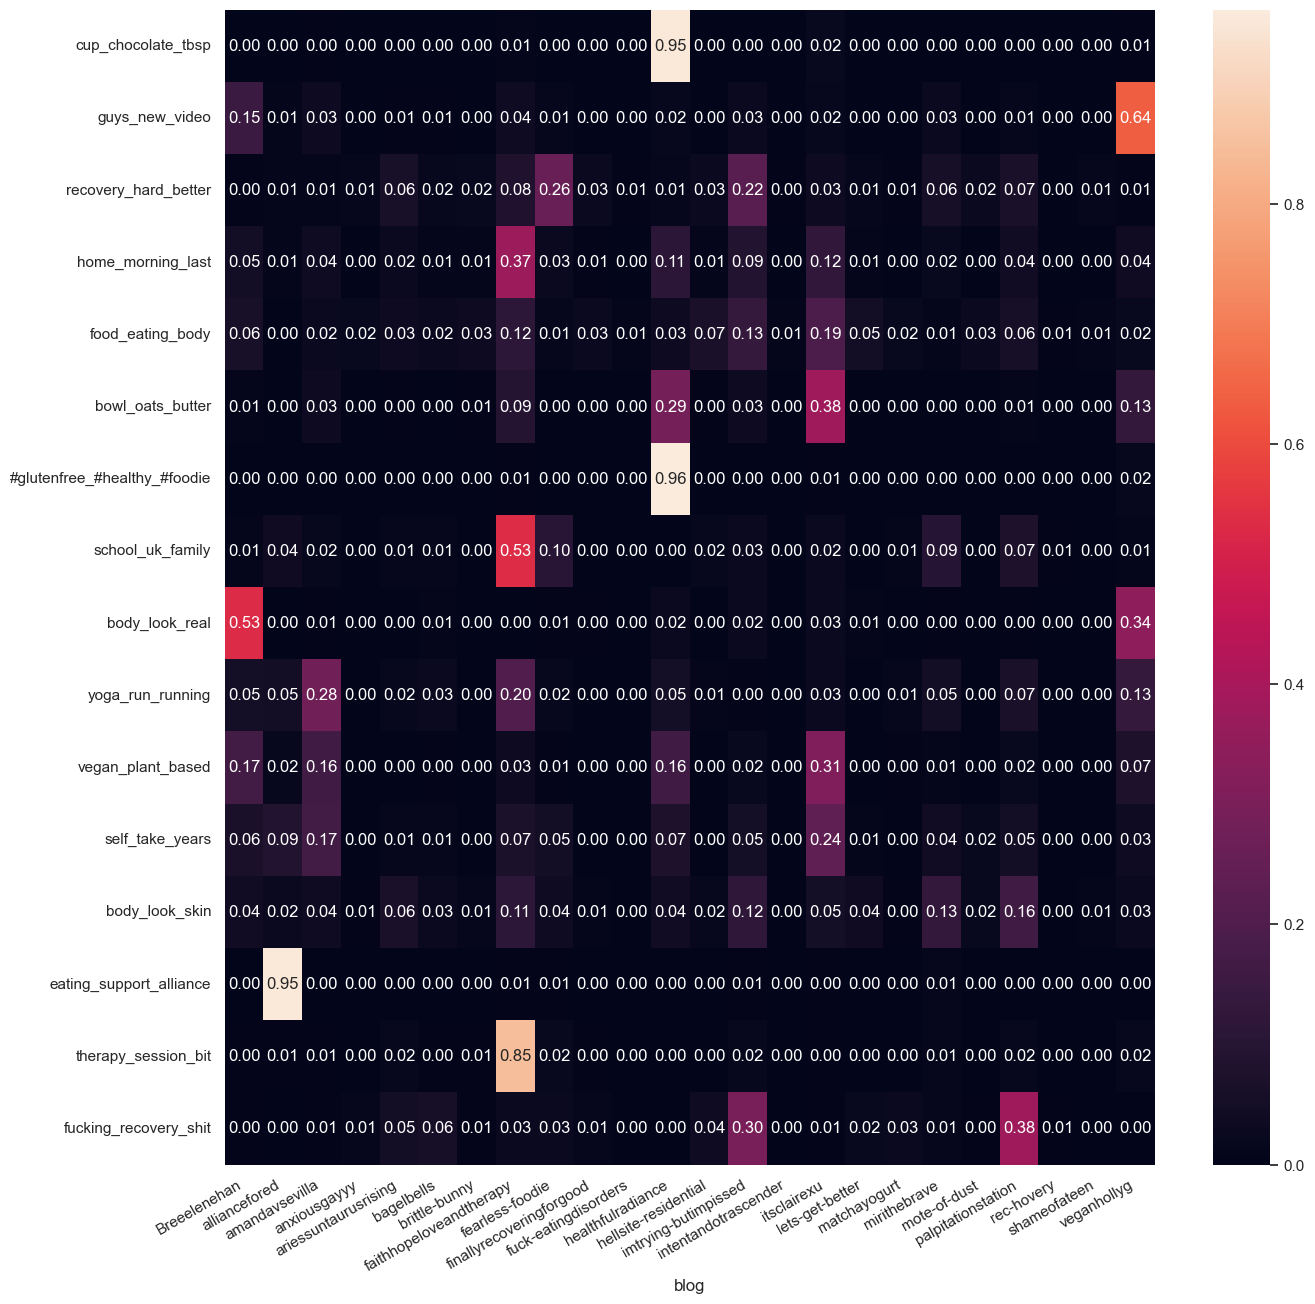

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(ddist_blog.iloc[:,0:-1].astype('float').T,fmt=".2f",annot=True)

plt.xticks(rotation=30,ha='right') 
plt.savefig('./result/edml/lda_nodejs.svg')
# plt.show()

In [44]:
list(text_df[text_df.id == 16638].url)

['https://faithhopeloveandtherapy.tumblr.com/post/189209497991/strangecupoftea-we-must-risk-unlearning-what']

In [49]:
topics[0][2]

'#glutenfree_#healthy_#foodie'

In [58]:
topic_num = 13
top_terms_n = 10

df = pd.DataFrame()

for i in range(topic_num):
    temp_df = pd.DataFrame(text_df.sort_values('Topic'+str(i)+'_dist',ascending=False).head(20)[['original_text','url']])
    temp_df['topic'] = topics[i][2]
    #bold the terms in top terms
    topic_top_terms = top_terms[i].split()[0:top_terms_n]
    temp_df['top_terms'] = '_'.join(topic_top_terms)
    texts = list(temp_df['original_text'])
    for i in range(len(texts)):
        for term in topic_top_terms:
            texts[i] = texts[i].replace(term,'<b>{0}</b>'.format(term))
    temp_df['original_text'] = texts
    df = pd.concat([temp_df,df])

df.iloc[-1].original_text,df.iloc[-1].top_terms

("like a regular loaded veg bowl, but elevated 🤷🏻\u200d♀️ all of my current faves in one spot. doesn't get better than that 🤤 i'm out for the rest of the day, hope it's been a good one for you all! ▪️▪️▪️▪️▪️▪️▪️▪️▪️▪️\nroasted purple brussel sprouts, roasted curry cauliflower, roasted zucchini chunks, loaded eggplant stew, roasted carrot chips, sun-dried tomato cashew cream, olive oil drizzle\n.\n.\n<b>#healthy</b> <b>#healthy</b>food #vegan #thefeedfeed #thefeedfeedvegan #mbg #thechalkboardeats #foodgrams <b>#wellness</b> #blogger #hbfit #wellandgoodeats #curry #vegancurry <b>#fitness</b> #healthblogger <b>#healthy</b>recipe #whatveganseat #buzzfeedfood #blogger <b>#healthy</b>dinner <b>#healthy</b>stew #veggiebowl #kale #veganfoodspace #grainfree <b>#glutenfree</b> #paleo #eggplant #cauli #roastedveg",
 '#glutenfree_#healthy_#foodie_#healthyfood_#foodblogger_#wellness_#healthyinspo_#healthylife_#plantpower_#fitness')

In [56]:
df

,original_text,url,topic
6786,Guess who just booked the next #<b>holly</b>go...,https://www.instagram.com/p/Ce0X-05N5pB/,guys_new_video
7325,"Sorry for another pic from May Ball, but it ga...",https://www.instagram.com/p/BVzNLpAlcru/,guys_new_video
6740,Come with us to the mountains 🏔✨ Episode of t...,https://www.instagram.com/p/CidKIngAr2e/,guys_new_video
1487,Wanted to say a huge THANK YOU for all the lov...,https://www.instagram.com/p/BwBq2mBhJQ1/,guys_new_video
7197,I love London 🇬🇧 But one of my favourite thing...,https://www.instagram.com/p/Bmu8FutAvTm/,guys_new_video
...,...,...,...
3315,hitting all my OG followers in their feels wit...,https://www.instagram.com/p/CAGbjJFJCiQ/,#glutenfree_#healthy_#foodie
3165,more...thanksgiving...leftovers... 😚 bc i know...,https://www.instagram.com/p/CIMHpXxD-8F/,#glutenfree_#healthy_#foodie
3078,on wednesday we *eat* pink...and on thursday w...,https://www.instagram.com/p/CNswcYqjwVC/,#glutenfree_#healthy_#foodie
2835,i just tried pasta salad for the first time…\n...,https://www.instagram.com/p/CgzUBB6q8L6/,#glutenfree_#healthy_#foodie


In [206]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

dataf_rnorm = robjects.DataFrame(ddist_blog.iloc[:,0:-1])
robjects.r(''' 
library(data.table)
topic.title.tall <- melt(setDT(ddist_blog), id.vars = c("title"), variable.name = "topic")
''')

KeyError: <class 'float'>

In [198]:
from plotnine import ggplot, aes, geom_line,geom_tile, scale_fill_gradient
(
ggplot(ddist_blog.iloc[:,0:-1], aes(x='blog')) +
    # geom_tile(aes(fill = value)) + 
    # geom_text(aes(label = round(value, 2))) +
    scale_fill_gradient(low = "white", high = "red")
    # +theme(text = element_text(size=20),axis.text.x = element_text(angle=45, hjust=1))
)

PlotnineError: "Could not evaluate the 'x' mapping: 'blog' (original error: name 'blog' is not defined)"

In [199]:
ddist_blog

,eating_support_alliance_us,bowl_oats_butter_almond,life_body_feel_like,roasted_#healthy_oil_add,body_like_feel_day,day_time_one_like,cup_chocolate_butter_add,id
blog,,,,,,,,
Breeelenehan,0.004505,0.011943,0.032642,0.002196,0.805447,0.123988,0.006482,1873399
alliancefored,0.901694,0.000727,0.074312,0.0,0.035109,0.021241,0.000715,6127291
amandavsevilla,0.009553,0.019371,0.158634,0.015112,0.018207,0.11161,0.005156,6136628
anxiousgayyy,0.000502,0.0,0.020532,0.000634,0.002199,0.002959,0.0,132541
healthfulradiance,0.009095,0.587512,0.09613,0.699153,0.027373,0.112608,0.944535,14710522
imtrying-butimpissed,0.024045,0.015182,0.285263,0.004865,0.031289,0.040838,0.0,1490061
itsclairexu,0.036686,0.293368,0.30226,0.09059,0.05645,0.139927,0.03727,14539093
veganhollyg,0.013919,0.071898,0.030227,0.187451,0.023927,0.446829,0.005842,12825333
